# Install Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install fastdtw

In [3]:
!pip install statsmodels

In [4]:
!pip install tensorflow

In [5]:
# library imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Conv1D, GRU, AveragePooling1D, Input, Concatenate, Add, Permute, Reshape, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from statsmodels.tsa.arima.model import ARIMA

from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.arima_model import ARIMA

from scipy.spatial.distance import euclidean
from scipy.ndimage import gaussian_filter1d

from fastdtw import fastdtw

import re

2024-05-20 03:22:47.125536: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 03:22:47.672142: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 03:22:47.675965: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 03:22:49.456572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
!pip install --upgrade h5py

ERROR: Could not install packages due to an EnvironmentError: HTTPSConnectionPool(host='files.pythonhosted.org', port=443): Max retries exceeded with url: /packages/86/43/fd0bd74462b3c3fb35d98568935d3e5a435c8ec24d45ef408ac8869166af/h5py-3.11.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f00f0001040>: Failed to establish a new connection: [Errno -2] Name or service not known'))



In [6]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Implement prediction models
- ACRNN (proposed model)
- LSTM, SVM, ARIMA (used as baseline comparison to ACRNN)

First a function to compile and fit tensorflow models. Early stopping with a validation split of 0.2 is used to prevent the models from overfitting.

Loss is mean squared error and the Adam optimiser is used for optimisation.

In [149]:
def compile_and_fit(model, X_train, y_train, patience=20, MAX_EPOCHS=1000, batch = 64):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(X_train, y_train, batch_size=batch, epochs=MAX_EPOCHS,
                      validation_split=0.2,
                      callbacks=[early_stopping])

    return history, model

## Simple LSTM

In [25]:
def fit_predict_LSTM(X_train, y_train, X_test, L=1, batch = 80):
    ''' Inputs:
      X_train and X_test are numpy arrays of the shape (num_train/test, time, features)
      L - the number of time steps to predict into the future

      Outputs:
      predicted array of shape (num_test, L, features)
      '''
    num_features = y_train.shape[-1]
    print(y_train.shape)
    lstm_model = Sequential([
                  # Shape [batch, time, features] => [batch, time, lstm_units]
                  LSTM(32, return_sequences=False),
                  # Shape => [batch, L*features]
                  Dense(units = num_features*L),
                  Reshape((L, num_features))
                  ])

    _, lstm_model = compile_and_fit(lstm_model, X_train, y_train, batch = batch)
    predictions = lstm_model(X_test).numpy()
    return predictions

## SVM

In [37]:
def fit_predict_svm(X_train, y_train, X_test):
  regr = svm.SVR()
  regr.fit(X_train, y_train)
  predictions = regr.predict(X_test)
  return predictions

## ARIMA

Note: Need to implement time series cross validation to include ARIMA model

In [26]:
def fit_predict_arima(X_train):
    model = ARIMA(X_train, order=(5,1,0))
    model_fit = model.fit()
    return model_fit.forecast()[0]

## Autoregressive Convolution Recurrent Neural Network Model(ACRNN)

In [150]:
class ACRNN(Model):

    def __init__(self, num_features, L, N_f=10, kernel_size=3, gru_units=5,):
        super(ACRNN, self).__init__()

        self.downsample05 = AveragePooling1D(pool_size=2, strides=2)
        self.downsample025 = AveragePooling1D(pool_size=4, strides=4)

        self.conv1_1 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                            data_format='channels_last', dilation_rate=1, groups=1,
                            activation='relu', use_bias=True, kernel_regularizer=None,
                            bias_regularizer=None)
        self.conv1_2 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                            data_format='channels_last', dilation_rate=1, groups=1,
                            activation='relu', use_bias=True, kernel_regularizer=None,
                            bias_regularizer=None)

        self.conv05_1 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                            data_format='channels_last', dilation_rate=1, groups=1,
                            activation='relu', use_bias=True, kernel_regularizer=None,
                            bias_regularizer=None)
        self.conv05_2 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                            data_format='channels_last', dilation_rate=1, groups=1,
                            activation='relu', use_bias=True, kernel_regularizer=None,
                            bias_regularizer=None)

        self.conv025_1 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                            data_format='channels_last', dilation_rate=1, groups=1,
                            activation='relu', use_bias=True, kernel_regularizer=None,
                            bias_regularizer=None)
        self.conv025_2 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                            data_format='channels_last', dilation_rate=1, groups=1,
                            activation='relu', use_bias=True, kernel_regularizer=None,
                            bias_regularizer=None)

        self.gru1 = GRU(gru_units, activation='tanh', recurrent_activation='sigmoid',
                        use_bias=True, kernel_regularizer=None,
                        recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                        dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False)
        self.gru05 = GRU(gru_units, activation='tanh', recurrent_activation='sigmoid',
                        use_bias=True, kernel_regularizer=None,
                        recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                        dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False)
        self.gru025 = GRU(gru_units, activation='tanh', recurrent_activation='sigmoid',
                        use_bias=True, kernel_regularizer=None,
                        recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                        dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False)

        self.concat = Concatenate()

        #note instead of L linear layers with j outputs have L*j and reshape
        self.w_rec = Dense(num_features*L, activation=None) # W_rec, output_shape (batch, features*L)
        self.reshape_o = Reshape((L,num_features))

        self.permute_1 = Permute((2, 1)) #(batch, features, time) since want linear model to act on time for all features
        self.w_lin = Dense(L, activation=None) # W_lin (T,L), output_shape (batch, features, L)
        self.permute_2 = Permute((2, 1)) #(batch, L, features)

        self.add = Add()

    def call(self, inputs):
        G1 = self.conv1_2(self.conv1_1(inputs))
        G05 = self.conv05_2(self.conv05_1(self.downsample05(inputs)))
        G025 = self.conv025_2(self.conv025_1(self.downsample025(inputs)))

        h1 = self.gru1(G1)
        h05 = self.gru05(G05)
        h025 = self.gru025(G025)

        h = self.concat([h1, h05, h025])
        o = self.w_rec(h)
        o = self.reshape_o(o)
        l = self.permute_2(self.w_lin(self.permute_1(inputs[:,-5:,:]))) # select only last 5

        return self.add([o, l])

In [151]:
def fit_predict_acrnn(X_train, y_train, X_test, L=1, batch = 80):
    ''' Inputs:
      X_train and X_test are numpy arrays of the shape (num_train/test, time, features)

      Outputs:
      predicted array of shape (num_test, features)
      '''

    num_features = X_train.shape[2]
    acrnn_model = ACRNN(num_features, L = L)

    _, acrnn_model = compile_and_fit(acrnn_model, X_train, y_train, batch = batch)
    predictions = acrnn_model(X_test).numpy()
    return predictions

#### with functional api to plot model graph
Just to visualize the model and check the architecture

In [127]:
# test hear with functional api to plot model graph

input_shape = (20,4)# input shape of original time series (time, features)
num_features = input_shape[1]
N_f = 10 # number of filters
kernel_size = 2 # kernel size for conv1D
units = 5 # GRU units
L = 7 # number of predicted time steps ahead

inputs = Input(shape=input_shape)
# downsample
x1 = inputs
x2 = AveragePooling1D(pool_size=2, strides=2)(inputs)
x3 = AveragePooling1D(pool_size=4, strides=4)(inputs)

#causal convolutions (batch, time, features)
x1 = Conv1D(
    N_f, kernel_size, strides=1, padding='causal',
    data_format='channels_last', dilation_rate=1, groups=1,
    activation='relu', use_bias=True, kernel_regularizer=None,
    bias_regularizer=None)(x1)
x1 = Conv1D(
  N_f, kernel_size, strides=1, padding='causal',
  data_format='channels_last', dilation_rate=1, groups=1,
  activation='relu', use_bias=True, kernel_regularizer=None,
  bias_regularizer=None)(x1)

x2 = Conv1D(
    N_f, kernel_size, strides=1, padding='causal',
    data_format='channels_last', dilation_rate=1, groups=1,
    activation='relu', use_bias=True, kernel_regularizer=None,
    bias_regularizer=None)(x2)
x2 = Conv1D(
    N_f, kernel_size, strides=1, padding='causal',
    data_format='channels_last', dilation_rate=1, groups=1,
    activation='relu', use_bias=True, kernel_regularizer=None,
    bias_regularizer=None)(x2)

x3 = Conv1D(
    N_f, kernel_size, strides=1, padding='causal',
    data_format='channels_last', dilation_rate=1, groups=1,
    activation='relu', use_bias=True, kernel_regularizer=None,
    bias_regularizer=None)(x3)
x3 = Conv1D(
    N_f, kernel_size, strides=1, padding='causal',
    data_format='channels_last', dilation_rate=1, groups=1,
    activation='relu', use_bias=True, kernel_regularizer=None,
    bias_regularizer=None)(x3)


# GRU
h1 = GRU(
    units, activation='tanh', recurrent_activation='sigmoid',
    use_bias=True, kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False)(x1)
h2 = GRU(
    units, activation='tanh', recurrent_activation='sigmoid',
    use_bias=True, kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False)(x2)
h3 = GRU(
    units, activation='tanh', recurrent_activation='sigmoid',
    use_bias=True, kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False)(x3)

# concatenate GRU last hidden states
h = Concatenate()([h1, h2, h3]) # output_shape = (batch, units*3)
o_t = Dense(num_features*L, activation=None)(h) # W_rec, output_shape (batch, features*L)
o_t = Reshape((L,num_features))(o_t)
inputs_permuted = Permute((2, 1))(inputs[:,-5:,:]) #permute to (batch, features, time)
l = Dense(L, activation=None)(inputs_permuted) # W_lin (T,L), output_shape (batch, features, L)
l = Permute((2,1))(l)
outputs = Add()([o_t, l])
model = Model(inputs, outputs)

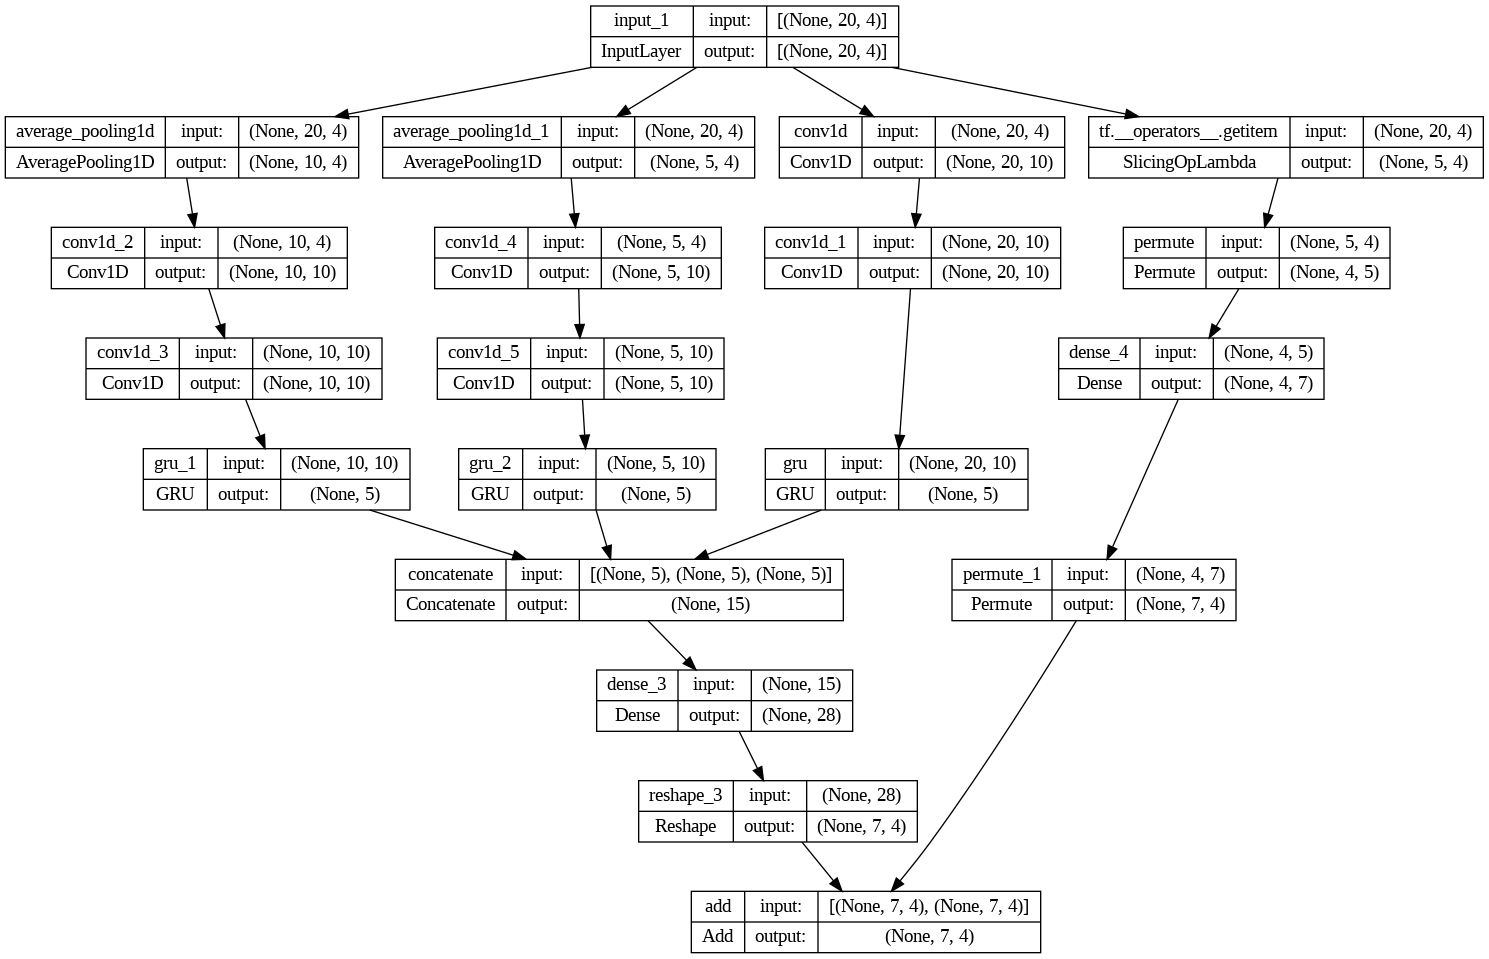

In [ ]:
tf.keras.utils.plot_model(
    model, show_shapes=True)

## Function to run cross validation for given data set

In [29]:
# function to compute dwt for each sample and return average distance
def array_dtw(true, predicted):
    distance = np.zeros((true.shape[0],))
    for i in range(true.shape[0]):
        distance[i] = fastdtw(true[i,:,:] , predicted[i,:,:], dist=euclidean)[0]
    return np.mean(distance)

In [30]:
array_dtw(np.random.normal(size=(20,3,1)), np.random.normal(size=(20,3,1)))

3.180106605636758

In [31]:
def k_fold_cv(k, X, y, batch_size=80):
    '''
    Inpuits:
      X - numpy array containing observed window of shape (num_samples, time, features), note time = 0 mode 4
      y - numpy array containing target of shape (num_samples, L, features) ### potentially add L here if want to but does not make sense atm

      Outputs:
      dictionary: saving average test mse, mae and dtw for each model
      '''
    L = y.shape[1]
    # create folds
    kf = KFold(n_splits=k)
    kf.get_n_splits(X)
    predictions = {}
    mse = {}
    mae = {}
    dtw = {}

    # loop over folds
    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        predictions['lstm'] = fit_predict_LSTM(X_train, y_train, X_test, L=L, batch = batch_size)
        predictions['acrnn'] = fit_predict_acrnn(X_train, y_train, X_test, L=L, batch = batch_size)

        # other svm and arima for one step and additional metrics mse & mae
        if L == 1:
            predictions['svm'] = fit_predict_svm(X_train.squeeze(), y_train.squeeze(), X_test.squeeze())
            y_test = y_test.squeeze()
            #predictions['arima'] = fit_predict_arima(X_train, y_train, X_test)
            for key in predictions:
                if key in mse: # if already have a loss value, append to list
                    mse[key].append(mean_squared_error(y_test , predictions[key].squeeze()))
                    mae[key].append(mean_absolute_error(y_test , predictions[key].squeeze()))
                else: # else create entry in dictionary
                    mse[key] = [mean_squared_error(y_test , predictions[key].squeeze())]
                    mae[key] = [mean_absolute_error(y_test , predictions[key].squeeze())]

        # dtw for multistep
        else:
            for key in predictions:
                if key in dtw:
                    dtw[key].append(array_dtw(y_test , predictions[key]))
                else:
                    dtw[key] = [array_dtw(y_test , predictions[key])]

    if L==1:
        return mse, mae
    else:
        return dtw

# Model Fitting & Visualization
- train the model on both national and city level inputs
- train the model on both univariate and multivariate time-series data

### National Level Inputs
- Mortgage Rate, AL, Credit, GDP, CPI, Treasury, Corp debt, Umemployment, BCI

In [152]:
# iterate window extractor over time series:
def window_generator(timeseries,window_width, target_width):
    '''
    inputs:
    timeseries - (time, features) array

    outputs X, y
    X - (num_samples, window_width, features) array with windows of width window_width over time series
    y - (num_samples, target_width, features) array with target windows of width target_width over time series
    '''
    X = []
    y = []

    for i in range(len(timeseries) - window_width - target_width):
        x_i, y_i = list(timeseries[i:(window_width+i)]), list(timeseries[(window_width+i):(window_width+target_width+i)])
        X.append(x_i)
        y.append(y_i)

    X = np.array(X)
    y = np.array(y)
    # add feature dimension (on variable)
    #X = np.expand_dims(X,-1)
    #y = np.expand_dims(y,-1)
    return X, y

In [153]:
def k_fold_cv_multi(k, X, y, batch_size=64):
  '''
  Inpuits:
  X - numpy array containing observed window of shape (num_samples, time, features), note time = 0 mode 4
  y - numpy array containing target of shape (num_samples, L, features) ### potentially add L here if want to but does not make sense atm

  Outputs:
  dictionary: saving average test mse, mae and dtw for each model
  '''
  L = y.shape[1]
  # create folds
  kf = KFold(n_splits=k)
  kf.get_n_splits(X)
  predictions = {}
  mse = {}
  mae = {}
  dtw = {}

  # loop over folds
  for train_index, test_index in kf.split(X):

      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      predictions['lstm'] = fit_predict_LSTM(X_train, y_train, X_test, L=L, batch = batch_size)
      predictions['acrnn'] = fit_predict_acrnn(X_train, y_train, X_test, L=L, batch = batch_size)

      # other svm and arima for one step and additional metrics mse & mae
      if L == 1:
        #predictions['svm'] = fit_predict_svm(X_train.squeeze(), y_train.squeeze(), X_test.squeeze())
        y_test = y_test.squeeze()
        #predictions['arima'] = fit_predict_arima(X_train, y_train, X_test)
        for key in predictions:
          if key in mse: # if already have a loss value, append to list
            mse[key].append(mean_squared_error(y_test , predictions[key].squeeze()))
            mae[key].append(mean_absolute_error(y_test , predictions[key].squeeze()))
          else: # else create entry in dictionary
            mse[key] = [mean_squared_error(y_test , predictions[key].squeeze())]
            mae[key] = [mean_absolute_error(y_test , predictions[key].squeeze())]

      # dtw for multistep
      else:
        for key in predictions:
          if key in dtw:
            dtw[key].append(array_dtw(y_test , predictions[key]))
          else:
            dtw[key] = [array_dtw(y_test , predictions[key])]

  if L==1:
    return mse, mae
  else:
    return dtw

In [143]:
data = pd.read_csv('national.csv')
data.set_index('Date', inplace=True)

In [144]:
data

,Mortgage_Rate,AL,AL_monthly,GDP,CPI,Treasury,Credit_Availability,Corp_debt,Unemployment,BusinessConfidenceIndex
Date,,,,,,,,,,
1976-06-01,8.90,2.202657,26.647846,1875.149333,56.700,0.84,0.000000,6.299447e+05,7.6,101.00330
1976-07-01,8.98,2.187029,26.457201,1886.558000,57.000,1.12,0.000000,6.347010e+05,7.8,100.64430
1976-08-01,9.00,2.183151,26.409896,1902.463000,57.300,1.16,0.000000,6.409817e+05,7.8,100.32090
1976-09-01,8.97,2.188972,26.480907,1918.368000,57.600,1.22,0.000000,6.472623e+05,7.6,100.09800
1976-10-01,8.90,2.202657,26.647846,1934.273000,57.900,1.39,0.000000,6.535430e+05,7.7,100.00210
...,...,...,...,...,...,...,...,...,...,...
2023-06-01,6.71,2.715597,32.897719,27427.756000,304.003,-1.06,3722.666667,3.288898e+07,3.6,98.53253
2023-07-01,6.81,2.688042,32.562487,27610.128000,304.628,-0.91,20346.000000,3.316733e+07,3.5,98.59760
2023-08-01,7.18,2.589933,31.368331,27725.751333,306.187,-0.76,2006.333333,3.344539e+07,3.8,98.70704


In [145]:
data_normalized = (data - data.mean()) / data.std()
data_smoothed = gaussian_filter1d(data_normalized, sigma=1, axis=0)

In [154]:
X_national, y_national = window_generator(data_smoothed, 150, 1)

Make sure the dimension matches

In [155]:
print(X_national.shape)
print(y_national.shape)

(418, 150, 10)
(418, 1, 10)


Fitting the model

In [56]:
national_mse, national_mae = k_fold_cv_multi(5, X_national, y_national)

Epoch 1/1000
4/4 [==============================] - 8s 571ms/step - loss: 1.4174 - mean_absolute_error: 0.9034 - val_loss: 3.5413 - val_mean_absolute_error: 1.6321
Epoch 2/1000
4/4 [==============================] - 0s 102ms/step - loss: 1.2394 - mean_absolute_error: 0.8560 - val_loss: 3.2843 - val_mean_absolute_error: 1.5766
Epoch 3/1000
4/4 [==============================] - 1s 135ms/step - loss: 1.0980 - mean_absolute_error: 0.8168 - val_loss: 3.0618 - val_mean_absolute_error: 1.5305
Epoch 4/1000
4/4 [==============================] - 0s 97ms/step - loss: 0.9849 - mean_absolute_error: 0.7816 - val_loss: 2.8540 - val_mean_absolute_error: 1.4862
Epoch 5/1000
4/4 [==============================] - 0s 89ms/step - loss: 0.8908 - mean_absolute_error: 0.7478 - val_loss: 2.6703 - val_mean_absolute_error: 1.4416
Epoch 6/1000
4/4 [==============================] - 0s 94ms/step - loss: 0.8163 - mean_absolute_error: 0.7166 - val_loss: 2.5019 - val_mean_absolute_error: 1.3955
Epoch 7/1000
4/4 [=

In [66]:
national_mse_mean = {}
national_mse_std = {}
national_mae_mean = {}
national_mae_std = {}

for key in national_mse:
    national_mse_mean[key] = np.mean(national_mse[key])
    national_mse_std[key] = np.std(national_mse[key])
    national_mae_mean[key] = np.mean(national_mae[key])
    national_mae_std[key] = np.std(national_mae[key])

In [67]:
print('national MSE mean', national_mse_mean)
print('national MSE standard deviation', national_mse_std)
print('national MAE mean', national_mae_mean)
print('national MAE standard deviation', national_mae_std)

national MSE mean {'acrnn': 0.11587923732941383}
national MSE standard deviation {'acrnn': 0.09418174159678998}
national MAE mean {'acrnn': 0.22419323606779437}
national MAE standard deviation {'acrnn': 0.09464875990488726}


### City Level Inputs
- add more features according to different citeis
- also modify the model and functions to use all features to predict HPI

get dallas data first

In [55]:
!pip install keras_tuner

     |████████████████████████████████| 129 kB 3.4 MB/s eta 0:00:01


#### finding best lag

In [89]:
data = pd.read_csv('national_dallas-2.csv', index_col=0, parse_dates=True)
data

,Mortgage_Rate,AL,AL_monthly,GDP,CPI,Treasury,Credit_Availability,Corp_debt,unemployment,BusinessConfidenceIndex,Regimes,usedauto,retailauto,luxury,HPI,mhi
Date,,,,,,,,,,,,,,,,
1976-06-01,8.90,2.202657,26.647846,1875.149333,56.700,0.84,0.000000,6.299447e+05,7.6,101.0033,1.0,6316.198257,8.430,196.555219,43.456667,46479.138953
1976-07-01,8.98,2.187029,26.457201,1886.558000,57.000,1.12,0.000000,6.347010e+05,7.8,100.6443,2.0,5875.572671,8.549,199.011836,42.430000,46546.327481
1976-08-01,9.00,2.183151,26.409896,1902.463000,57.300,1.16,0.000000,6.409817e+05,7.8,100.3209,2.0,5676.242843,7.990,197.769412,42.330000,46622.637434
1976-09-01,8.97,2.188972,26.480907,1918.368000,57.600,1.22,0.000000,6.472623e+05,7.6,100.0980,2.0,4900.893494,8.452,208.573511,42.230000,46690.763108
1976-10-01,8.90,2.202657,26.647846,1934.273000,57.900,1.39,0.000000,6.535430e+05,7.7,100.0021,2.0,4934.239112,7.710,209.403898,42.130000,46766.810182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,3.01,4.159715,50.338327,24379.393000,273.887,1.24,58892.333333,2.922112e+07,4.7,101.5773,3.0,14450.000000,1.871,210.913000,346.256667,68430.333333
2021-10-01,3.14,4.090719,49.511638,24654.603000,276.434,1.07,74341.000000,2.961722e+07,4.5,101.5794,3.0,14669.000000,1.906,221.258000,351.230000,69040.500000
2021-11-01,3.10,4.111766,49.763897,24779.440667,278.799,0.91,59484.333333,2.987846e+07,4.1,101.4980,3.0,13427.000000,2.083,228.572000,357.850000,69650.666667


In [90]:
data_normalized = (data - data.mean()) / data.std()
data_smoothed = gaussian_filter1d(data_normalized, sigma=1, axis=0)

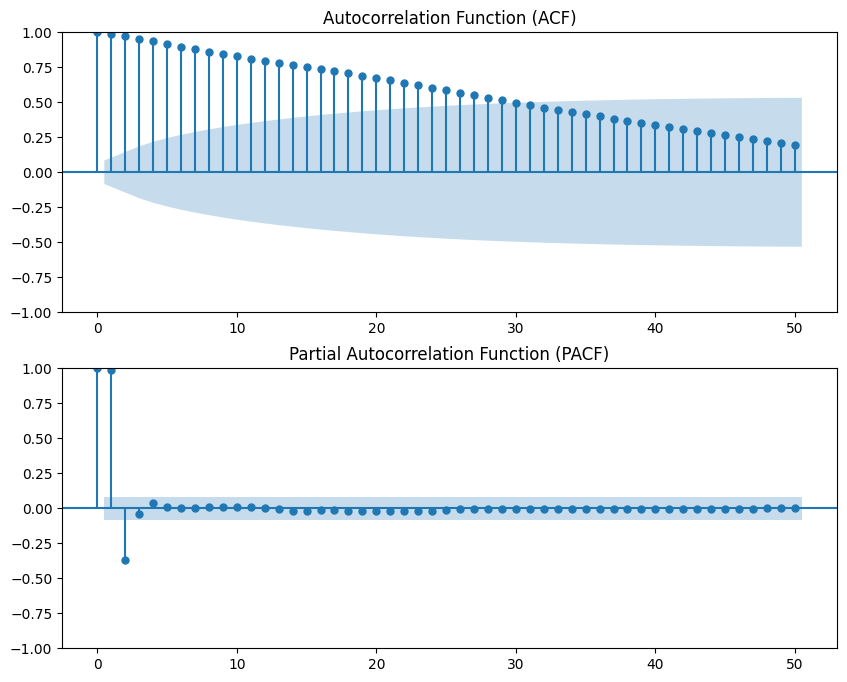

In [91]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example data for the HPI column (target column)
hpi_series = pd.Series(data_smoothed[:, 15])

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# ACF plot
plot_acf(hpi_series, lags=50, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(hpi_series, lags=50, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()

best lag might range in (1,4)

In [104]:
X_lag,y_lag = window_generator_new(data_smoothed, 150, 1, target_index=15)

print(X_lag.shape)
print(y_lag.shape)

(392, 150, 16)
(392, 1, 1)


In [94]:
def create_lagged_features(df, target_column, lags):
    for lag in lags:
        df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)
    return df

In [108]:
# Create lagged features for HPI based on significant lags
significant_lags = [1, 2, 3, 4]

# Example DataFrame with HPI column
df = pd.DataFrame(data_smoothed, columns=[f'feature_{i}' for i in range(data_smoothed.shape[1])])
df['HPI'] = hpi_series  # Add the HPI column

# Create lagged features
df_lagged = create_lagged_features(df, 'HPI', significant_lags)

# Drop rows with NaN values created by lagging
df_lagged.dropna(inplace=True)

# Update the dataset
data_smoothed_lagged = df_lagged.values
X_lagged = data_smoothed_lagged[:, :-1]  # Exclude the target column
y_lagged = data_smoothed_lagged[:, -1].reshape(-1, 1)  # Target column

# Generate windows for the lagged dataset
X_lag,y_lag = window_generator_new(data_smoothed_lagged, 150, 1, target_index=15)

# Perform k-fold cross-validation with the lagged dataset
mse_lagged, mae_lagged = k_fold_cv_multi(2, X_lag, y_lag)

Epoch 1/1000
3/3 [==============================] - 3s 375ms/step - loss: 0.2389 - mean_absolute_error: 0.4257 - val_loss: 1.2107 - val_mean_absolute_error: 1.0840
Epoch 2/1000
3/3 [==============================] - 0s 125ms/step - loss: 0.0875 - mean_absolute_error: 0.2510 - val_loss: 0.6664 - val_mean_absolute_error: 0.7947
Epoch 3/1000
3/3 [==============================] - 0s 123ms/step - loss: 0.0357 - mean_absolute_error: 0.1558 - val_loss: 0.3983 - val_mean_absolute_error: 0.6022
Epoch 4/1000
3/3 [==============================] - 0s 126ms/step - loss: 0.0217 - mean_absolute_error: 0.1225 - val_loss: 0.2835 - val_mean_absolute_error: 0.4970
Epoch 5/1000
3/3 [==============================] - 0s 113ms/step - loss: 0.0138 - mean_absolute_error: 0.0940 - val_loss: 0.2530 - val_mean_absolute_error: 0.4645
Epoch 6/1000
3/3 [==============================] - 0s 131ms/step - loss: 0.0165 - mean_absolute_error: 0.1150 - val_loss: 0.2633 - val_mean_absolute_error: 0.4751
Epoch 7/1000
3/3

In [109]:
mse_lagged, mae_lagged

({'lstm': [1.3875529351312026, 0.35767365818852626],
  'acrnn': [0.5503657235795865, 2.124522721311457]},
 {'lstm': [0.9979036916383824, 0.4695472575597308],
  'acrnn': [0.57333356367478, 1.25570083989864]})

In [110]:
# Plot predicted vs actual for a single fold using the lagged dataset
y_true_lagged = y_lag.squeeze()
y_pred_acrnn_lagged = fit_predict_acrnn(X_lag, y_lag, X_lag, L=1).squeeze()
y_pred_lstm_lagged = fit_predict_LSTM(X_lag, y_lag, X_lag, L=1).squeeze()

Epoch 1/1000
4/4 [==============================] - 8s 429ms/step - loss: 0.5255 - mean_absolute_error: 0.5738 - val_loss: 2.5538 - val_mean_absolute_error: 1.5081
Epoch 2/1000
4/4 [==============================] - 0s 102ms/step - loss: 0.2814 - mean_absolute_error: 0.4078 - val_loss: 2.9692 - val_mean_absolute_error: 1.6321
Epoch 3/1000
4/4 [==============================] - 0s 97ms/step - loss: 0.1420 - mean_absolute_error: 0.2829 - val_loss: 3.1942 - val_mean_absolute_error: 1.6958
Epoch 4/1000
4/4 [==============================] - 0s 99ms/step - loss: 0.0817 - mean_absolute_error: 0.2069 - val_loss: 3.2192 - val_mean_absolute_error: 1.7018
Epoch 5/1000
4/4 [==============================] - 0s 111ms/step - loss: 0.0578 - mean_absolute_error: 0.1817 - val_loss: 3.0404 - val_mean_absolute_error: 1.6501
Epoch 6/1000
4/4 [==============================] - 0s 106ms/step - loss: 0.0419 - mean_absolute_error: 0.1596 - val_loss: 2.7362 - val_mean_absolute_error: 1.5591
Epoch 7/1000
4/4 [

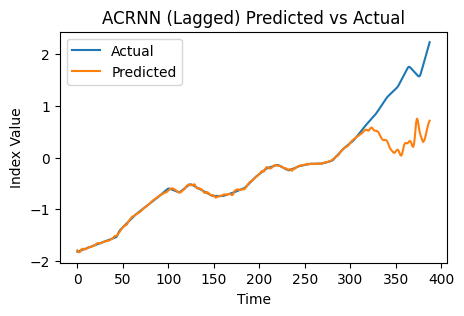

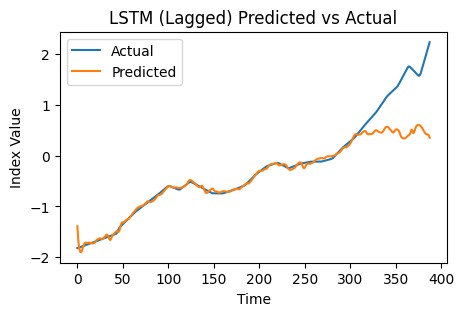

In [111]:
# plot pred vs actual
plot_predicted_vs_actual(y_true_lagged, y_pred_acrnn_lagged, "ACRNN (Lagged)")
plot_predicted_vs_actual(y_true_lagged, y_pred_lstm_lagged, "LSTM (Lagged)")

#### modify the model to use all columns to predict hpi only

In [84]:
dallas = pd.read_csv('dallas.csv')
dallas.set_index('Date', inplace=True)
dallas.head()

,Mortgage_Rate,AL,AL_monthly,GDP,CPI,Treasury,Credit_Availability,Corp_debt,Unemployment,BusinessConfidenceIndex,HPI,MHI
Date,,,,,,,,,,,,
1989-01-01,10.60,1.907128,23.042128,5511.253000,121.2,-0.11,2436.000000,2.740898e+06,5.4,100.35170,93.570000,30570.0
1989-02-01,10.78,1.879853,22.709367,5544.989667,121.6,-0.23,2844.333333,2.760573e+06,5.2,100.12410,93.683333,30634.5
1989-03-01,11.19,1.820211,21.981825,5578.726333,122.2,-0.43,3252.666667,2.780248e+06,5.0,99.82473,93.796667,30699.0
1989-04-01,11.03,1.843086,22.260843,5612.463000,123.1,-0.20,3661.000000,2.799923e+06,5.2,99.53631,93.910000,30763.5
1989-05-01,10.50,1.922581,23.230663,5640.097000,123.7,-0.22,4110.000000,2.819092e+06,5.2,99.13468,94.463333,30828.0


In [85]:
dallas_normalized = (dallas - dallas.mean()) / dallas.std()
dallas_smoothed = gaussian_filter1d(dallas_normalized, sigma=1, axis=0)

modify the code for model

In [98]:
def compile_and_fit(model, X_train, y_train, patience=20, MAX_EPOCHS=1000, batch=64):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(X_train, y_train, batch_size=batch, epochs=MAX_EPOCHS,
                        validation_split=0.2,
                        callbacks=[early_stopping])

    return history, model

In [99]:
class ACRNN(Model):
    def __init__(self, num_features, L, N_f=10, kernel_size=3, gru_units=5):
        super(ACRNN, self).__init__()
        self.downsample05 = AveragePooling1D(pool_size=2, strides=2)
        self.downsample025 = AveragePooling1D(pool_size=4, strides=4)

        self.conv1_1 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                              data_format='channels_last', dilation_rate=1, groups=1,
                              activation='relu', use_bias=True)
        self.conv1_2 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                              data_format='channels_last', dilation_rate=1, groups=1,
                              activation='relu', use_bias=True)

        self.conv05_1 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                               data_format='channels_last', dilation_rate=1, groups=1,
                               activation='relu', use_bias=True)
        self.conv05_2 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                               data_format='channels_last', dilation_rate=1, groups=1,
                               activation='relu', use_bias=True)

        self.conv025_1 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                                data_format='channels_last', dilation_rate=1, groups=1,
                                activation='relu', use_bias=True)
        self.conv025_2 = Conv1D(N_f, kernel_size, strides=1, padding='causal',
                                data_format='channels_last', dilation_rate=1, groups=1,
                                activation='relu', use_bias=True)

        self.gru1 = GRU(gru_units, activation='tanh', recurrent_activation='sigmoid',
                        use_bias=True, return_sequences=False)
        self.gru05 = GRU(gru_units, activation='tanh', recurrent_activation='sigmoid',
                         use_bias=True, return_sequences=False)
        self.gru025 = GRU(gru_units, activation='tanh', recurrent_activation='sigmoid',
                          use_bias=True, return_sequences=False)

        self.concat = Concatenate()
        self.w_rec = Dense(1 * L, activation=None)  # Predict only the target feature
        self.reshape_o = Reshape((L, 1))

    def call(self, inputs):
        G1 = self.conv1_2(self.conv1_1(inputs))
        G05 = self.conv05_2(self.conv05_1(self.downsample05(inputs)))
        G025 = self.conv025_2(self.conv025_1(self.downsample025(inputs)))

        h1 = self.gru1(G1)
        h05 = self.gru05(G05)
        h025 = self.gru025(G025)

        h = self.concat([h1, h05, h025])
        o = self.w_rec(h)
        o = self.reshape_o(o)
        return o


In [100]:
def fit_predict_acrnn(X_train, y_train, X_test, L=1, batch=80):
    '''
    Inputs:
    X_train and X_test are numpy arrays of the shape (num_train/test, time, features)
    
    Outputs:
    predicted array of shape (num_test, L, 1)
    '''
    num_features = X_train.shape[2]
    acrnn_model = ACRNN(num_features, L=L)

    _, acrnn_model = compile_and_fit(acrnn_model, X_train, y_train, batch=batch)
    predictions = acrnn_model(X_test).numpy()
    # Ensure predictions are reshaped to (num_test, L, 1)
    return predictions


In [101]:
def fit_predict_LSTM(X_train, y_train, X_test, L=1, batch=80):
    '''
    Inputs:
    X_train and X_test are numpy arrays of the shape (num_train/test, time, features)
    L - the number of time steps to predict into the future

    Outputs:
    predicted array of shape (num_test, L, 1)
    '''
    num_features = y_train.shape[-1]
    lstm_model = Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        LSTM(32, return_sequences=False),
        # Shape => [batch, L*1]
        Dense(units=1 * L),
        Reshape((L, 1))
    ])

    _, lstm_model = compile_and_fit(lstm_model, X_train, y_train, batch=batch)
    predictions = lstm_model(X_test).numpy()
    # Ensure predictions are reshaped to (num_test, L, 1)
    return predictions


In [102]:
def window_generator_new(timeseries, window_width, target_width, target_index):
    X = []
    y = []

    for i in range(len(timeseries) - window_width - target_width):
        x_i = list(timeseries[i:(window_width+i)])
        y_i = list(timeseries[(window_width+i):(window_width+target_width+i), target_index])
        X.append(x_i)
        y.append(y_i)

    X = np.array(X)
    y = np.array(y)
    # add feature dimension (on variable)
    # X = np.expand_dims(X, -1)
    y = np.expand_dims(y, -1)
    return X, y

In [103]:
def k_fold_cv_new(k, X, y, batch_size=80):
    '''
    Inputs:
    X - numpy array containing observed window of shape (num_samples, time, features)
    y - numpy array containing target of shape (num_samples, L, 1)

    Outputs:
    dictionary: saving average test mse, mae, and dtw for each model
    '''
    L = y.shape[1]
    kf = KFold(n_splits=k)
    kf.get_n_splits(X)
    predictions = {}
    mse = {}
    mae = {}
    dtw = {}

    # Loop over folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Make predictions with LSTM model
        predictions['lstm'] = fit_predict_LSTM(X_train, y_train, X_test, L=L, batch=batch_size)
        # Make predictions with ACRNN model
        predictions['acrnn'] = fit_predict_acrnn(X_train, y_train, X_test, L=L, batch=batch_size)

        if L == 1:
            y_test = y_test.squeeze()
            for key in predictions:
                if key in mse:
                    mse[key].append(mean_squared_error(y_test, predictions[key].squeeze()))
                    mae[key].append(mean_absolute_error(y_test, predictions[key].squeeze()))
                else:
                    mse[key] = [mean_squared_error(y_test, predictions[key].squeeze())]
                    mae[key] = [mean_absolute_error(y_test, predictions[key].squeeze())]
        else:
            for key in predictions:
                if key in dtw:
                    dtw[key].append(array_dtw(y_test, predictions[key]))
                else:
                    dtw[key] = [array_dtw(y_test, predictions[key])]

    if L == 1:
        return mse, mae
    else:
        return dtw


fitting the model and making predictions

In [191]:
X_dallas,y_dallas = window_generator_new(dallas_smoothed, 150, 1, target_index=10)

In [217]:
print(X_dallas.shape)
print(y_dallas.shape)

(246, 150, 12)
(246, 1, 1)


In [199]:
# hpi
target_index = 10
X_dallas, y_dallas = window_generator_new(dallas_smoothed, 150, 1, target_index)

# Perform k-fold cross-validation, only use 2 for less computation time, could try for 5
mse, mae = k_fold_cv_new(2, X_dallas, y_dallas)

Epoch 1/1000
2/2 [==============================] - 2s 484ms/step - loss: 1.6731 - mean_absolute_error: 1.0712 - val_loss: 6.4555 - val_mean_absolute_error: 2.4908
Epoch 2/1000
2/2 [==============================] - 0s 122ms/step - loss: 1.2320 - mean_absolute_error: 0.8925 - val_loss: 5.2029 - val_mean_absolute_error: 2.2308
Epoch 3/1000
2/2 [==============================] - 0s 114ms/step - loss: 0.8666 - mean_absolute_error: 0.7485 - val_loss: 4.1402 - val_mean_absolute_error: 1.9827
Epoch 4/1000
2/2 [==============================] - 0s 105ms/step - loss: 0.5822 - mean_absolute_error: 0.6070 - val_loss: 3.2580 - val_mean_absolute_error: 1.7489
Epoch 5/1000
2/2 [==============================] - 0s 130ms/step - loss: 0.3756 - mean_absolute_error: 0.4802 - val_loss: 2.5405 - val_mean_absolute_error: 1.5307
Epoch 6/1000
2/2 [==============================] - 0s 131ms/step - loss: 0.2394 - mean_absolute_error: 0.3807 - val_loss: 1.9751 - val_mean_absolute_error: 1.3311
Epoch 7/1000
2/2

In [218]:
print("MSE:", mse)
print("MAE:", mae)

MSE: {'lstm': [0.04678716163411788, 1.6537999874499079], 'acrnn': [0.1332995918472156, 2.474053736727482]}
MAE: {'lstm': [0.18406692465059674, 1.0332852143207678], 'acrnn': [0.28608643957454644, 1.3086160845379182]}


In [219]:
mse_mean = {}
mse_std = {}
mae_mean = {}
mae_std = {}

for key in mse:
    mse_mean[key] = np.mean(mse[key])
    mse_std[key] = np.std(mse[key])
    mae_mean[key] = np.mean(mae[key])
    mae_std[key] = np.std(mae[key])

print('MSE mean', mse_mean)
print('MSE standard deviation', mse_std)
print('MAE mean', mae_mean)
print('MAE standard deviation', mae_std)

MSE mean {'lstm': 0.8502935745420128, 'acrnn': 1.303676664287349}
MSE standard deviation {'lstm': 0.803506412907895, 'acrnn': 1.1703770724401332}
MAE mean {'lstm': 0.6086760694856823, 'acrnn': 0.7973512620562323}
MAE standard deviation {'lstm': 0.42460914483508555, 'acrnn': 0.5112648224816859}


### Visualizing Model Results

In [51]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predicted_vs_actual(y_true, y_pred, model_name):
    plt.figure(figsize=(5, 3))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f'{model_name} Predicted vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Index Value')
    plt.legend()
    plt.show()

def plot_fold_metrics(mse, mae, model_name):
    plt.figure(figsize=(5, 3))
    plt.plot(mse, label='MSE')
    plt.plot(mae, label='MAE')
    plt.title(f'{model_name} MSE and MAE Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('Metric')
    plt.legend()
    plt.show()

- First: loss curve for national inputs
- Second: loss curve for dallas

Epoch 1/1000
6/6 [==============================] - 6s 245ms/step - loss: 0.7774 - mean_absolute_error: 0.6734 - val_loss: 1.6915 - val_mean_absolute_error: 1.1475
Epoch 2/1000
6/6 [==============================] - 1s 85ms/step - loss: 0.5763 - mean_absolute_error: 0.5786 - val_loss: 1.3276 - val_mean_absolute_error: 0.9849
Epoch 3/1000
6/6 [==============================] - 1s 89ms/step - loss: 0.5405 - mean_absolute_error: 0.5333 - val_loss: 1.3493 - val_mean_absolute_error: 0.9472
Epoch 4/1000
6/6 [==============================] - 1s 90ms/step - loss: 0.5314 - mean_absolute_error: 0.5066 - val_loss: 1.3195 - val_mean_absolute_error: 0.9487
Epoch 5/1000
6/6 [==============================] - 1s 88ms/step - loss: 0.5210 - mean_absolute_error: 0.4987 - val_loss: 1.2900 - val_mean_absolute_error: 0.9670
Epoch 6/1000
6/6 [==============================] - 1s 86ms/step - loss: 0.5154 - mean_absolute_error: 0.5065 - val_loss: 1.2902 - val_mean_absolute_error: 0.9803
Epoch 7/1000
6/6 [===

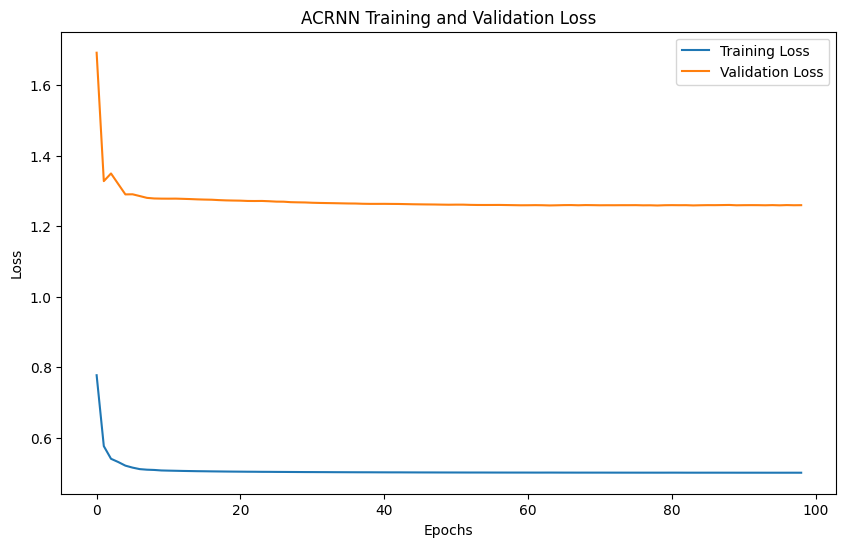

In [204]:
# Example: Plot training history for the first fold of ACRNN
history, _ = compile_and_fit(ACRNN(X_national.shape[2], L=1), X_national, y_national)
plot_training_history(history, "ACRNN")

Epoch 1/1000
4/4 [==============================] - 11s 462ms/step - loss: 0.3978 - mean_absolute_error: 0.5343 - val_loss: 5.6649 - val_mean_absolute_error: 2.3305
Epoch 2/1000
4/4 [==============================] - 0s 92ms/step - loss: 0.2410 - mean_absolute_error: 0.3927 - val_loss: 4.7063 - val_mean_absolute_error: 2.1188
Epoch 3/1000
4/4 [==============================] - 0s 104ms/step - loss: 0.1655 - mean_absolute_error: 0.3166 - val_loss: 4.0135 - val_mean_absolute_error: 1.9514
Epoch 4/1000
4/4 [==============================] - 0s 83ms/step - loss: 0.1274 - mean_absolute_error: 0.2758 - val_loss: 3.5327 - val_mean_absolute_error: 1.8251
Epoch 5/1000
4/4 [==============================] - 0s 126ms/step - loss: 0.1041 - mean_absolute_error: 0.2482 - val_loss: 3.2125 - val_mean_absolute_error: 1.7353
Epoch 6/1000
4/4 [==============================] - 0s 104ms/step - loss: 0.0851 - mean_absolute_error: 0.2234 - val_loss: 3.0259 - val_mean_absolute_error: 1.6793
Epoch 7/1000
4/4 

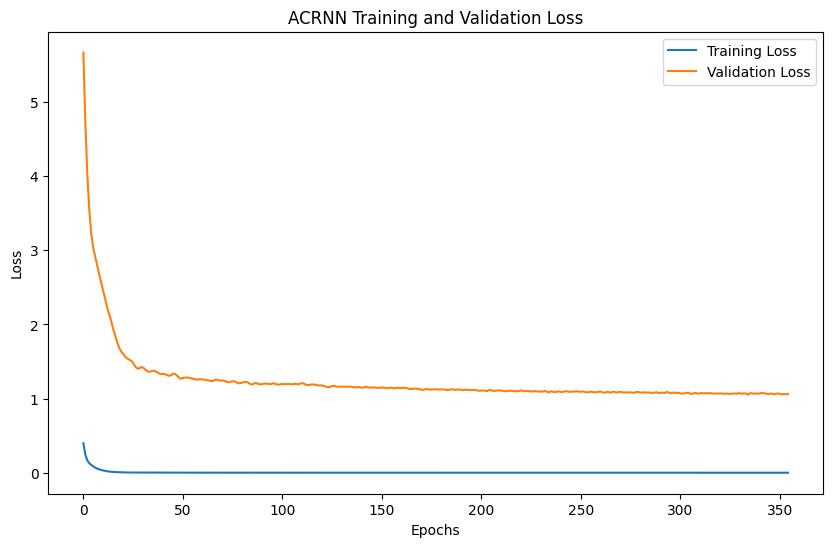

In [215]:
# Example: Plot training history for the first fold of ACRNN
history, _ = compile_and_fit(ACRNN(X_dallas.shape[2], L=1), X_dallas, y_dallas)
plot_training_history(history, "ACRNN")

- Predicted vs Actual
- Dallas, HPI

Epoch 1/1000
3/3 [==============================] - 7s 598ms/step - loss: 0.3168 - mean_absolute_error: 0.4085 - val_loss: 5.3670 - val_mean_absolute_error: 2.2740
Epoch 2/1000
3/3 [==============================] - 0s 101ms/step - loss: 0.2065 - mean_absolute_error: 0.3440 - val_loss: 3.9708 - val_mean_absolute_error: 1.9465
Epoch 3/1000
3/3 [==============================] - 0s 95ms/step - loss: 0.1428 - mean_absolute_error: 0.2954 - val_loss: 2.9732 - val_mean_absolute_error: 1.6744
Epoch 4/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.0982 - mean_absolute_error: 0.2412 - val_loss: 2.3504 - val_mean_absolute_error: 1.4782
Epoch 5/1000
3/3 [==============================] - 0s 93ms/step - loss: 0.0650 - mean_absolute_error: 0.1826 - val_loss: 1.9736 - val_mean_absolute_error: 1.3445
Epoch 6/1000
3/3 [==============================] - 0s 109ms/step - loss: 0.0449 - mean_absolute_error: 0.1557 - val_loss: 1.7524 - val_mean_absolute_error: 1.2578
Epoch 7/1000
3/3 [=

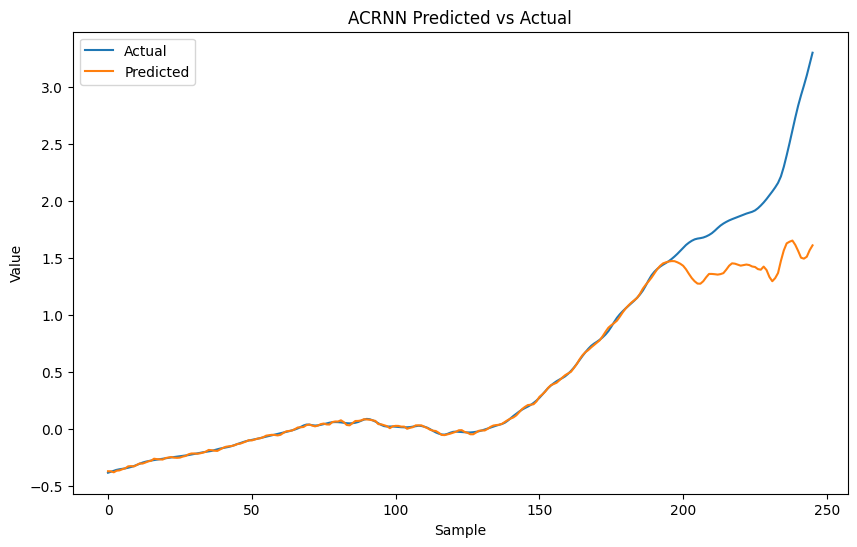

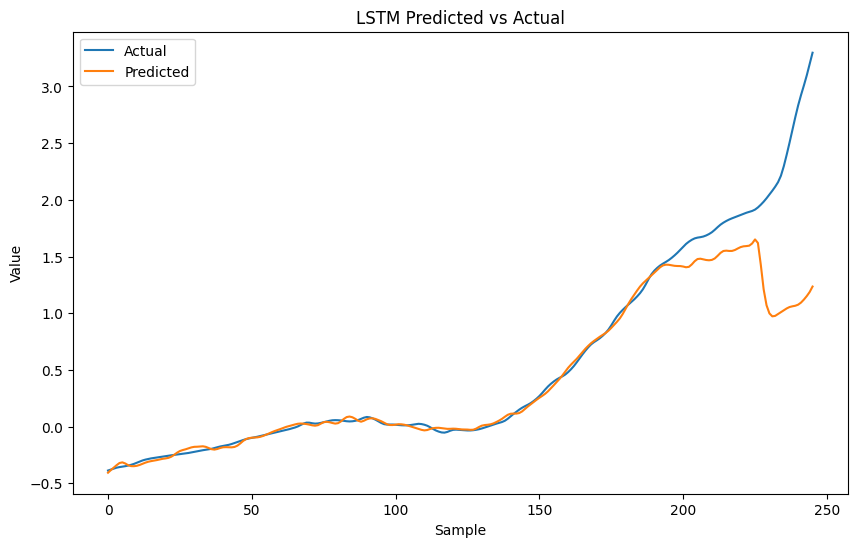

In [213]:
# Example: Plot predicted vs actual for a single fold
y_true = y_dallas.squeeze()
y_pred_acrnn = fit_predict_acrnn(X_dallas, y_dallas, X_dallas, L=1).squeeze()
y_pred_lstm = fit_predict_LSTM(X_dallas, y_dallas, X_dallas, L=1).squeeze()

plot_predicted_vs_actual(y_true, y_pred_acrnn, "ACRNN")
plot_predicted_vs_actual(y_true, y_pred_lstm, "LSTM")

- MSE, MAE across folds
- dallas

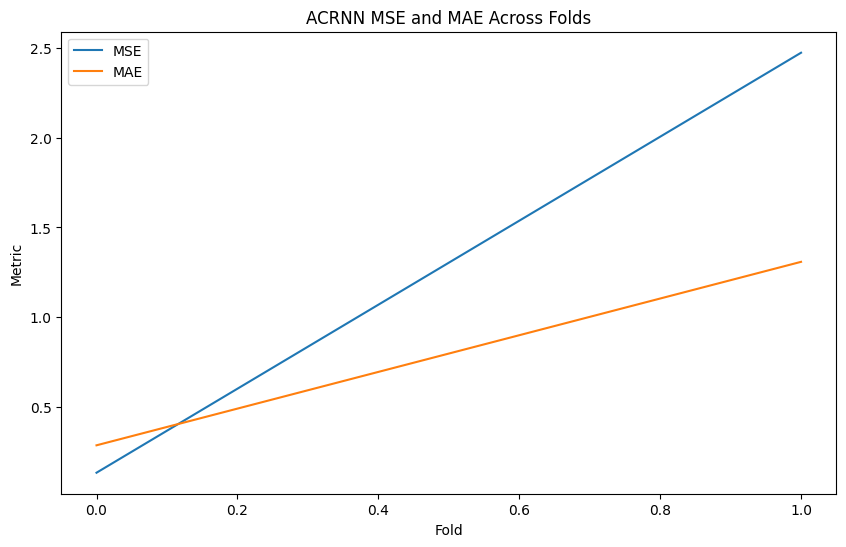

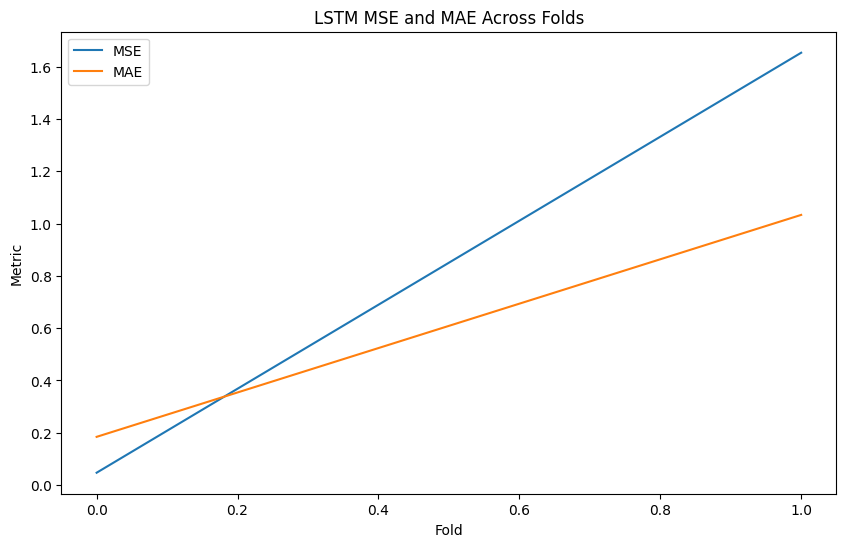

In [206]:
# Example: Plot MSE and MAE across folds
plot_fold_metrics(mse['acrnn'], mae['acrnn'], "ACRNN")
plot_fold_metrics(mse['lstm'], mae['lstm'], "LSTM")

### Train model with Univariate Time Series Data
- validate model assumption

#### gdp

In [19]:
!pip install fredapi
from fredapi import Fred
fred_api = "9c6b8642b1610c723e2571ed42640b15"
fred = Fred(api_key=fred_api)

In [ ]:
gdp = fred.get_series('GDP').dropna()
gdp = pd.DataFrame(gdp, columns=["GDP"])
gdp.index.name = 'Date'

In [ ]:
gdp_normalized = (gdp - gdp.mean()) / gdp.std()
gdp_smoothed = gaussian_filter1d(gdp_normalized, sigma=1, axis=0)

In [ ]:
gdp_normalized

,GDP
Date,
1947-01-01,-0.936473
1947-02-01,-0.936347
1947-03-01,-0.936222
1947-04-01,-0.936096
1947-05-01,-0.935934
...,...
2023-09-01,2.771889
2023-10-01,2.787425
2023-11-01,2.802094


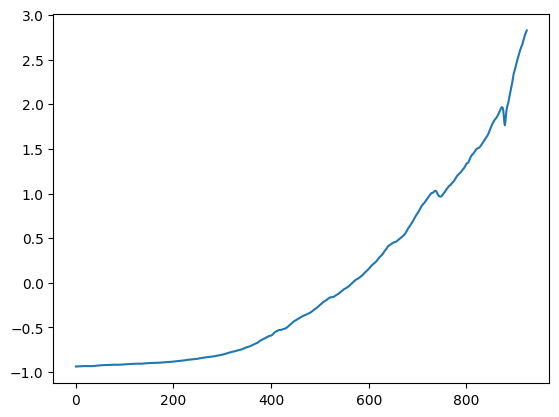

In [ ]:
plt.plot(gdp_smoothed)

In [ ]:
X_gdp, y_gdp = window_generator(gdp_smoothed, 15, 1)

In [ ]:
print(X_gdp.shape)
print(y_gdp.shape)

(293, 15, 1)
(293, 1, 1)


In [ ]:
gdp_mse, gdp_mae = k_fold_cv(2, X_gdp, y_gdp)

In [ ]:
print(gdp_mse)
print(gdp_mae)

{'lstm': [0.08853591711559662, 0.5191443648757648], 'acrnn': [0.0033274012482322796, 21.149804211529563], 'svm': [1.0324802751548745, 2.7820928475902456]}
{'lstm': [0.2866171835276785, 0.5644177904423111], 'acrnn': [0.051704797501260426, 3.8572823508981093], 'svm': [0.9511437891362754, 1.448548035739404]}


#### hpi

In [19]:
hpi = pd.read_csv('national_dallas-2.csv')
hpi.set_index('Date', inplace=True)
hpi = hpi.HPI

In [21]:
hpi_normalized = (hpi - hpi.mean()) / hpi.std()
hpi_smoothed = gaussian_filter1d(hpi_normalized, sigma=1, axis=0)

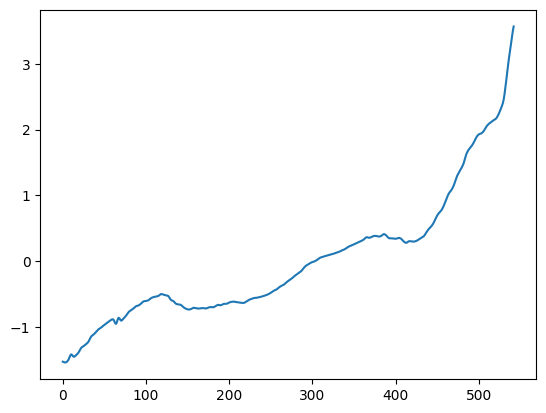

In [22]:
plt.plot(hpi_smoothed)

In [35]:
X_hpi, y_hpi = window_generator(hpi_smoothed, 15, 1)

print(X_hpi.shape)
print(y_hpi.shape)

(527, 15, 1)
(527, 1, 1)


In [38]:
mse, mae = k_fold_cv(2, X_hpi, y_hpi)

(263, 1, 1)
Epoch 1/1000
3/3 [==============================] - 2s 218ms/step - loss: 0.4146 - mean_absolute_error: 0.4640 - val_loss: 6.2187 - val_mean_absolute_error: 2.4410
Epoch 2/1000
3/3 [==============================] - 0s 34ms/step - loss: 0.3297 - mean_absolute_error: 0.4041 - val_loss: 5.3499 - val_mean_absolute_error: 2.2578
Epoch 3/1000
3/3 [==============================] - 0s 33ms/step - loss: 0.2549 - mean_absolute_error: 0.3457 - val_loss: 4.5608 - val_mean_absolute_error: 2.0776
Epoch 4/1000
3/3 [==============================] - 0s 34ms/step - loss: 0.1956 - mean_absolute_error: 0.2905 - val_loss: 3.8215 - val_mean_absolute_error: 1.8934
Epoch 5/1000
3/3 [==============================] - 0s 32ms/step - loss: 0.1428 - mean_absolute_error: 0.2360 - val_loss: 3.1326 - val_mean_absolute_error: 1.7039
Epoch 6/1000
3/3 [==============================] - 0s 29ms/step - loss: 0.0997 - mean_absolute_error: 0.1839 - val_loss: 2.4960 - val_mean_absolute_error: 1.5078
Epoch 7/1

In [45]:
mse_mean = {}
mse_std = {}
mae_mean = {}
mae_std = {}

for key in mse:
    mse_mean[key] = round(np.mean(mse[key]),4)
    mse_std[key] = round(np.std(mse[key]),4)
    mae_mean[key] = round(np.mean(mae[key]),4)
    mae_std[key] = round(np.std(mae[key]),4)

print('MSE mean', mse_mean)
print('MSE standard deviation', mse_std)
print('MAE mean', mae_mean)
print('MAE standard deviation', mae_std)

MSE mean {'lstm': 0.5334, 'acrnn': 0.7978, 'svm': 2.4574}
MSE standard deviation {'lstm': 0.4604, 'acrnn': 0.7711, 'svm': 0.7905}
MAE mean {'lstm': 0.4735, 'acrnn': 0.5596, 'svm': 1.3453}
MAE standard deviation {'lstm': 0.2462, 'acrnn': 0.4047, 'svm': 0.2134}


#### visualization

Epoch 1/1000
6/6 [==============================] - 6s 178ms/step - loss: 0.4080 - mean_absolute_error: 0.5533 - val_loss: 3.2734 - val_mean_absolute_error: 1.6395
Epoch 2/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.2351 - mean_absolute_error: 0.4264 - val_loss: 2.9574 - val_mean_absolute_error: 1.5640
Epoch 3/1000
6/6 [==============================] - 0s 22ms/step - loss: 0.1264 - mean_absolute_error: 0.3129 - val_loss: 2.6167 - val_mean_absolute_error: 1.4733
Epoch 4/1000
6/6 [==============================] - 0s 22ms/step - loss: 0.0697 - mean_absolute_error: 0.2130 - val_loss: 2.1985 - val_mean_absolute_error: 1.3450
Epoch 5/1000
6/6 [==============================] - 0s 22ms/step - loss: 0.0430 - mean_absolute_error: 0.1645 - val_loss: 1.7494 - val_mean_absolute_error: 1.1851
Epoch 6/1000
6/6 [==============================] - 0s 21ms/step - loss: 0.0277 - mean_absolute_error: 0.1466 - val_loss: 1.3243 - val_mean_absolute_error: 1.0074
Epoch 7/1000
6/6 [===

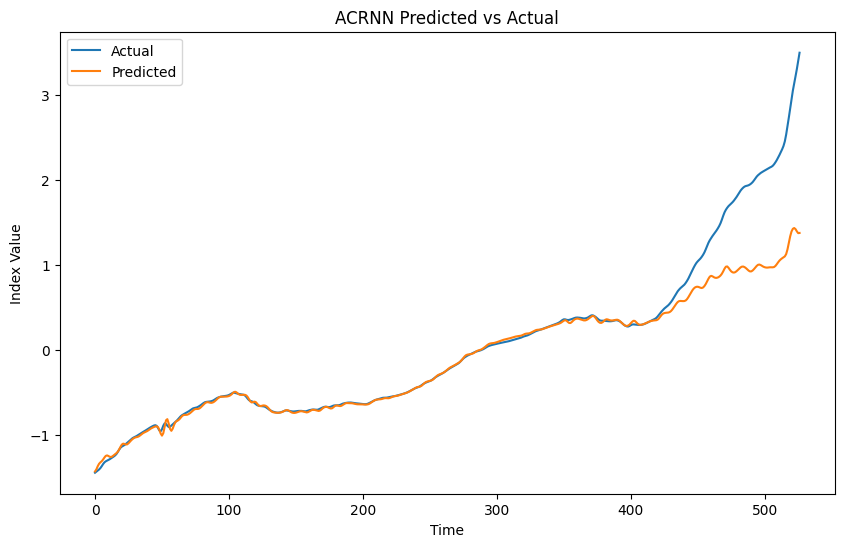

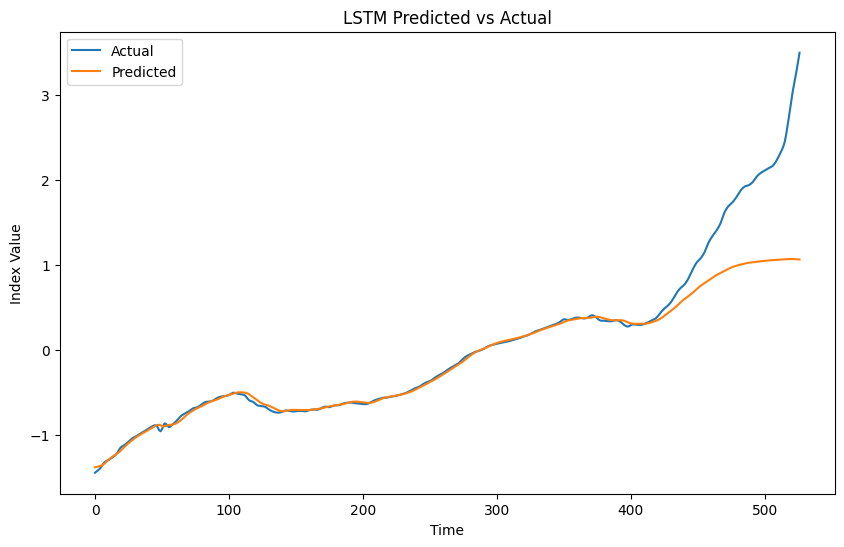

In [47]:
# Example: Plot predicted vs actual for a single fold
y_true = y_hpi.squeeze()
y_pred_acrnn = fit_predict_acrnn(X_hpi, y_hpi, X_hpi, L=1).squeeze()
y_pred_lstm = fit_predict_LSTM(X_hpi, y_hpi, X_hpi, L=1).squeeze()

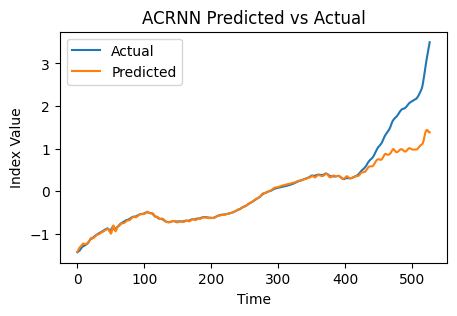

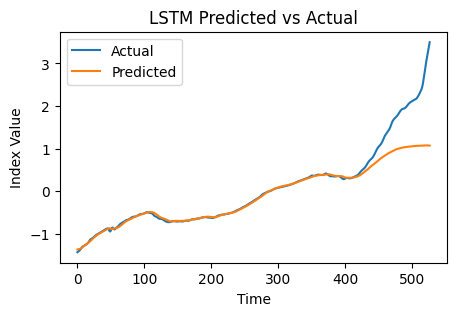

In [52]:
plot_predicted_vs_actual(y_true, y_pred_acrnn, "ACRNN")
plot_predicted_vs_actual(y_true, y_pred_lstm, "LSTM")